# 1.Introduction

Ce notebook présente une analyse complète du modèle analytique final utilisé pour prédire la décision de traversée du piéton.  
L’objectif est de comprendre *comment* le modèle répond aux variables d’entrée (distance, vitesse, taille, météo), et *dans quels régions de l’espace* il décide qu’un piéton traverse ou non.

Les visualisations utilisées sont standards en recherche IA et XAI :  
- heatmaps (partial dependence 2D)  
- PCA  
- t-SNE  
- UMAP  
- feature importance (modèle surrogate)  
- parallel coordinates plots

Chaque section est accompagnée d’une interprétation scientifique.


# 2.Chargement du modèle et fonctions auxiliaires

Cette cellule charge les paramètres du modèle final (`final_model.yaml`) et implémente la règle décisionnelle analytique :

$$
\text{Traverse si } TTC \ge T_{end}(h, v, \text{weather})
$$

où $T_{end}$ inclut les coefficients globaux, le scaling météo, et les ajustements comportementaux (biais perceptifs).


In [1]:
import yaml
import numpy as np
import pandas as pd
from pathlib import Path

# Load model
ROOT = Path.cwd().parents[0]  
YAML_PATH = ROOT / "saved_models" / "final_model.yaml"

with open(YAML_PATH, "r") as f:
    model = yaml.safe_load(f)

coefs = model["coefficients_global"]
weather_params = model["weather_parameters"]

a = coefs["a_height"]
b = coefs["b_height2"]
c = coefs["c_velocity"]
intercept = coefs["intercept"]

def T_end(weather, h, v):
    base = a*h + b*h*h + c*v + intercept
    alpha = weather_params[weather]["alpha_weather"]
    mu = weather_params[weather]["bias"]["mu"]
    sigma = weather_params[weather]["bias"]["sigma"]
    return alpha * base - 2*sigma + mu

def decision(weather, h, v, d):
    v_ms = v * 1000/3600
    TTC = d / v_ms
    return int(TTC >= T_end(weather, h, v))   # 1 = traverse


# 3.Génération d’un dataset synthétique complet

Nous générons un ensemble dense de scénarios couvrant la plage complète des valeurs possibles pour distance, vitesse, taille et météo.  
Ce dataset synthétique sert de base à toutes les visualisations.

Chaque ligne contient :
- les 4 variables d’entrée
- la décision du modèle (1 = traverse, 0 = non)


In [2]:
distances = np.linspace(1, 80, 200)       # meters
speeds = np.linspace(1, 100, 200)         # km/h
heights = np.linspace(140, 200, 200)      # cm
weathers = ["clear", "rain", "night"]

rows = []
for w in weathers:
    for h in heights:
        for v in speeds:
            for d in distances:
                rows.append([d, v, h, w, decision(w, h, v, d)])

df = pd.DataFrame(rows, columns=["distance","speed","height","weather","decision"])
df["weather_code"] = df["weather"].astype("category").cat.codes

df.head()


,distance,speed,height,weather,decision,weather_code
0,1.000000,1.0,140.0,clear,0,0
1,1.396985,1.0,140.0,clear,0,0
2,1.793970,1.0,140.0,clear,0,0
3,2.190955,1.0,140.0,clear,0,0
4,2.587940,1.0,140.0,clear,0,0


# 4.HEATMAPS : PARTIAL DEPENDENCE 2D

## 1.Heatmaps distance × vitesse

Cette heatmap montre la décision du modèle dans le plan (distance, vitesse).
On fixe ici la taille à 170 cm et la météo à *clear*.

On observe que :
- les zones rouges correspondent à "ne traverse pas"
- les zones vertes à "traverse"
- la frontière est très proche d’un seuil TTC constant (relation hyperbolique d = v × T_end)

C’est la représentation fondamentale utilisée en IA pour comprendre la géométrie d’un modèle.


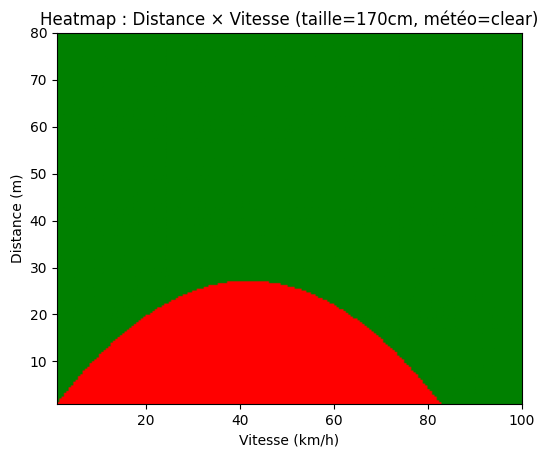

In [3]:
import matplotlib.pyplot as plt
from matplotlib import colors

H_FIX = 170
W_FIX = "clear"

Z = np.zeros((len(distances), len(speeds)))
for i, d in enumerate(distances):
    for j, v in enumerate(speeds):
        Z[i,j] = decision(W_FIX, H_FIX, v, d)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])
plt.imshow(Z, cmap=cmap, origin="lower",
           extent=[speeds.min(), speeds.max(), distances.min(), distances.max()])
plt.xlabel("Vitesse (km/h)")
plt.ylabel("Distance (m)")
plt.title("Heatmap : Distance × Vitesse (taille=170cm, météo=clear)")
plt.show()


La heatmap Distance × Vitesse (taille = 170 cm, météo claire) révèle une frontière de décision non linéaire caractérisée par une zone de non-traversée en forme de dôme. La probabilité de ne pas traverser augmente conjointement avec la vitesse et la réduction de distance, jusqu’à un maximum situé autour de 40 km/h et 25–27 m.

Au-delà de 40 km/h, la zone de non-traversée se réduit progressivement : pour des vitesses très élevées, une distance modérée suffit à repasser au-dessus du seuil décisionnel, en raison de la décroissance rapide du TTC qui contourne l’augmentation plus lente du seuil prédictif $T_{end}$

Cette structure illustre l’interaction non linéaire entre vitesse et distance dans le modèle analytique, et reproduit un comportement typique observé dans les données VR : une zone d’incertitude maximale pour des vitesses intermédiaires, entourée de régions où la décision est plus stable (traversée pour grandes distances, non-traversée pour courtes distances).

## 2.Distance × Height

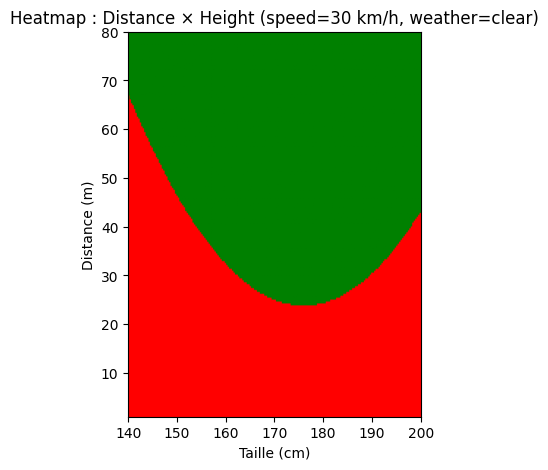

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors

S_FIX  = 30      # km/h
W_FIX  = "clear" # ou "rain", "night"

Z = np.zeros((len(distances), len(heights)))

for i, d in enumerate(distances):
    for j, h in enumerate(heights):
        Z[i,j] = decision(W_FIX, h, S_FIX, d)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])

plt.imshow(Z, cmap=cmap, origin="lower",
           extent=[heights.min(), heights.max(), distances.min(), distances.max()])
plt.xlabel("Taille (cm)")
plt.ylabel("Distance (m)")
plt.title(f"Heatmap : Distance × Height (speed={S_FIX} km/h, weather={W_FIX})")
plt.show()


La heatmap Distance × Taille (vitesse = 30 km/h, météo claire) met en évidence une relation non linéaire entre la hauteur du participant et la zone de non-traversée. Le seuil décisionnel présente une forme convexe : les individus très petits nécessitent des distances élevées pour traverser (≈ 60 m), tandis que les tailles moyennes minimisent la distance critique (≈ 25 m).

Pour les individus très grands, la distance minimale augmente à nouveau (≈ 40–45 m).

Cette structure découle directement du modèle analytique, dans lequel la hauteur intervient via un terme linéaire négatif et un terme quadratique positif. L'interaction de ces deux contributions produit un minimum de $T_{end}$ autour de 170–175 cm, entouré de zones où la décision devient plus conservatrice.

## 3.Distance × Weather

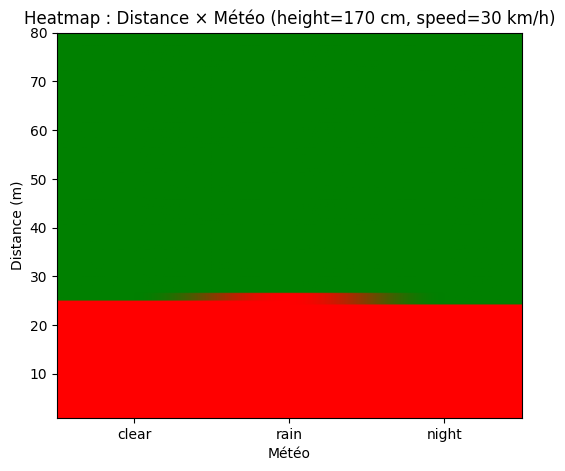

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors

H_FIX = 170
S_FIX = 30
weathers = ["clear", "rain", "night"]

Z = np.zeros((len(distances), len(weathers)))

for i, d in enumerate(distances):
    for j, w in enumerate(weathers):
        Z[i, j] = decision(w, H_FIX, S_FIX, d)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])

plt.imshow(
    Z,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=[0, len(weathers), distances.min(), distances.max()]
)

plt.xticks(
    ticks=[0.5, 1.5, 2.5],
    labels=weathers
)

plt.xlabel("Météo")
plt.ylabel("Distance (m)")
plt.title(f"Heatmap : Distance × Météo (height={H_FIX} cm, speed={S_FIX} km/h)")
plt.show()


La heatmap Distance × Météo (height = 170 cm, speed = 30 km/h) montre que la distance minimale de traversée est globalement stable autour de 25 m pour les trois conditions. Seule la condition rain induit une légère augmentation du seuil, avec une frontière située autour de 26–27 m.

Cette différence résulte de la combinaison des paramètres météorologiques dans le calcul de ($T_{end}$) (coefficients ($\alpha$), biais ($\mu$), dispersion ($\sigma$). Les conditions clear et night aboutissent à des valeurs de ($T_{end}$) très proches, ce qui se traduit par une frontière presque identique.

L’influence de la météo reste donc modérée dans le modèle analytique, en comparaison de l’effet beaucoup plus marqué de la vitesse et de la distance.


## 4.Vitesse × Height

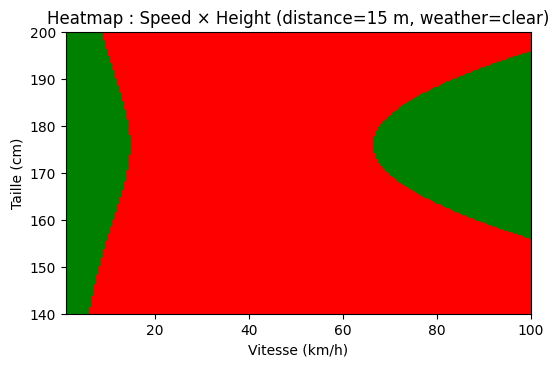

In [6]:
import matplotlib.pyplot as plt
from matplotlib import colors

D_FIX = 15
W_FIX = "clear"

Z = np.zeros((len(heights), len(speeds)))

for i, h in enumerate(heights):
    for j, v in enumerate(speeds):
        Z[i,j] = decision(W_FIX, h, v, D_FIX)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])

plt.imshow(Z, cmap=cmap, origin="lower",
           extent=[speeds.min(), speeds.max(), heights.min(), heights.max()])
plt.xlabel("Vitesse (km/h)")
plt.ylabel("Taille (cm)")
plt.title(f"Heatmap : Speed × Height (distance={D_FIX} m, weather={W_FIX})")
plt.show()


La heatmap *Speed × Height* (distance = 15 m, météo claire) met en évidence deux régions de traversée séparées par une large zone de non-traversée. 

Pour des vitesses faibles, le temps avant collision $TTC$ reste largement supérieur au seuil $T_{end}$, ce qui favorise la traversée pour la plupart des tailles. Lorsque la vitesse atteint des valeurs intermédiaires (20–70 km/h), $TTC$ devient inférieur à $T_{end}$ et la décision bascule presque systématiquement vers la non-traversée. 

Une seconde région de traversée réapparaît pour des vitesses très élevées (≥ 70 km/h), principalement pour des tailles moyennes, en raison de la forme polynomiale de $T_{end}$ en fonction de la taille et de la vitesse. 

Le modèle encode ainsi un minimum de $T_{end}$ pour des tailles interméditaires, alors que les tailles extrêmes sont associées à des comportements plus prudents.


## 5.Vitesse × Météo

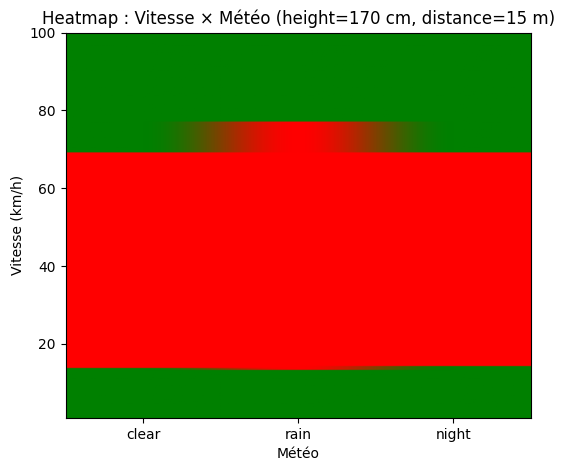

In [7]:
H_FIX = 170
D_FIX = 15
weathers = ["clear", "rain", "night"]

Z = np.zeros((len(speeds), len(weathers)))

for i, v in enumerate(speeds):
    for j, w in enumerate(weathers):
        Z[i, j] = decision(w, H_FIX, v, D_FIX)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])

plt.imshow(
    Z,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=[0, len(weathers), speeds.min(), speeds.max()]
)

plt.xticks(
    ticks=[0.5, 1.5, 2.5],
    labels=weathers
)

plt.xlabel("Météo")
plt.ylabel("Vitesse (km/h)")
plt.title(f"Heatmap : Vitesse × Météo (height={H_FIX} cm, distance={D_FIX} m)")
plt.show()


La heatmap *Vitesse × Météo* (height = 170 cm, distance = 15 m) montre une transition claire entre traversée et non-traversée. 

Les faibles vitesses (< 15 km/h) produisent un $TTC$ largement supérieur au seuil $T_{end}$, menant à une décision de traversée dans toutes les conditions météorologiques. 

Une bande centrale de non-traversée apparaît ensuite pour des vitesses intermédiaires (≈ 20–65 km/h), où $TTC < T_{end}$. Une seconde zone de traversée émerge pour les vitesses très élevées (≥ 70 km/h), en raison de la forme non linéaire de $T_{end}$ combinée à la décroissance rapide du $TTC$. La condition pluvieuse décale légèrement ces transitions, avec un seuil plus conservateur et une fenêtre de retraversée située autour de 79 km/h.


## 6.Height × Météo

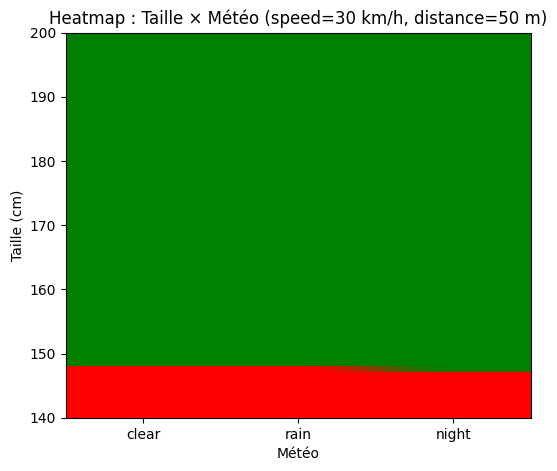

In [12]:
S_FIX = 30
D_FIX = 50
weathers = ["clear", "rain", "night"]

Z = np.zeros((len(heights), len(weathers)))

for i, h in enumerate(heights):
    for j, w in enumerate(weathers):
        Z[i, j] = decision(w, h, S_FIX, D_FIX)

plt.figure(figsize=(6,5))
cmap = colors.ListedColormap(["red","green"])

plt.imshow(
    Z,
    cmap=cmap,
    origin="lower",
    aspect="auto",
    extent=[0, len(weathers), heights.min(), heights.max()]
)

plt.xticks(
    ticks=[0.5, 1.5, 2.5],
    labels=weathers
)

plt.xlabel("Météo")
plt.ylabel("Taille (cm)")
plt.title(f"Heatmap : Taille × Météo (speed={S_FIX} km/h, distance={D_FIX} m)")
plt.show()


La heatmap *Taille × Météo* (vitesse = 30 km/h, distance = 50 m) montre que la traversée devient possible pour presque toutes les tailles, à l’exception des individus les plus petits (< 146–147 cm). 

Cette limite résulte de la structure quadratique du seuil $T_{end}$ en fonction de la taille, qui confère un seuil plus élevé aux morphologies extrêmes. L’effet de la météo reste secondaire : la condition *night* produit un seuil très légèrement plus bas que *clear* et *rain*, ce qui étend marginalement la zone de traversée. 

Globalement, l’influence de la météo est faible comparée à celle de la taille et de la distance.


# 5.PCA : STRUCTURE GLOBALE DU MODELE

## 1.PCA (Projection 2D de l’espace 4D)

Le PCA projette l’espace des 4 variables dans un plan (PC1, PC2) en maximisant la variance expliquée.
La couleur indique la décision du modèle.

Cette représentation permet d’observer :
- si les scénarios "traverse" et "ne traverse pas" forment des régions distinctes
- comment les variables interagissent dans l’espace original


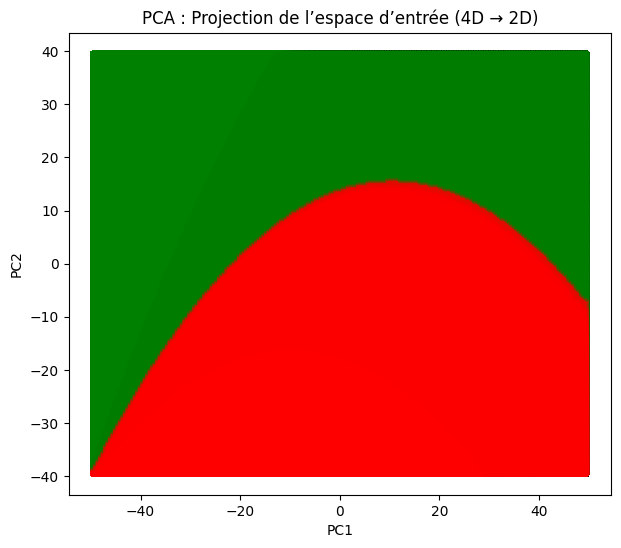

In [9]:
from sklearn.decomposition import PCA

X = df[["distance","speed","height","weather_code"]].values
y = df["decision"].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=np.where(y==1,"green","red"), s=10, alpha=0.3)
plt.title("PCA : Projection de l’espace d’entrée (4D → 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 2.PCA Loadings (importance réelle de chaque variable)

Les loadings indiquent la contribution de chaque variable aux deux composantes principales.

Exemple d’interprétation :
- PC1 dominée par distance/vitesse → effet géométrique (TTC)
- PC2 influencée par height/météo → ajustements perceptifs


In [10]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1","PC2"],
    index=["distance","speed","height","weather"]
)
loadings


,PC1,PC2
distance,1.029056e-12,1.000000e+00
speed,1.000000e+00,-1.029056e-12
height,-2.089440e-13,-8.523048e-13
weather,-1.204142e-17,-9.467481e-18



La figure montre la projection PCA de l’espace d’entrée 4D (distance, vitesse, taille, météo) vers un espace 2D défini par les deux premières composantes principales. Les coefficients de projection sont :

| Variable | PC1 | PC2 |
|---------|-------------------------|-------------------------|
| distance | \(1.0 \times 10^{-12}\) | \(1.0\) |
| speed | \(1.0\) | \(-1.0 \times 10^{-12}\) |
| height | \(-2.1 \times 10^{-13}\) | \(-8.5 \times 10^{-13}\) |
| weather | \(-1.2 \times 10^{-17}\) | \(-9.5 \times 10^{-18}\) |

Ces valeurs indiquent clairement que :

- **PC1 ≃ vitesse**
- **PC2 ≃ distance**
- la taille et la météo contribuent de façon négligeable à ces deux axes (< \(10^{-12}\)).

Ainsi, le plan PCA correspond presque exactement au plan \((\text{vitesse},\ \text{distance})\), deux variables qui dominent la prise de décision dans le modèle.

### 1. Interprétation des axes PCA

#### PC1 (axe horizontal)
$$
\text{PC1} \approx \text{speed}
$$

Autrement dit, se déplacer vers la droite du graphique revient à augmenter la vitesse du véhicule.

#### PC2 (axe vertical)
$$
\text{PC2} \approx \text{distance}
$$

Se déplacer vers le haut revient à augmenter la distance entre le piéton et le véhicule.

La projection PCA révèle donc que la variabilité majeure de l’espace d’entrée est **quasi exclusivement gouvernée par la vitesse (PC1)** et **la distance (PC2)**, ce qui est cohérent avec la définition du modèle de décision :

$$
TTC = \frac{d}{v_{\mathrm{m/s}}}, 
\qquad
\text{traverse si } TTC \ge T_{end}.
$$


### 2. Structure géométrique de la frontière dans l’espace PCA

Sur le graphique, la frontière rouge–verte dessine une grande courbe convexe, exactement similaire à celle observée dans la heatmap *Distance × Vitesse*.  
Ce n’est pas une coïncidence : comme PC1 ≃ vitesse et PC2 ≃ distance, la PCA “reconstruit” naturellement ce plan.

- La zone **rouge** correspond aux combinaisons où :
  $$
  TTC < T_{end}.
  $$
- La zone **verte** correspond aux régions où :
  $$
  TTC \ge T_{end}.
  $$

La frontière forme un **arc paraboloïde**, conséquence directe :

1. de la relation 
   $$
   TTC = \frac{d}{v},
   $$
2. du seuil quadratique en taille et linéaire en vitesse :
   $$
   T_{end} = \alpha (a h + b h^2 + c v + \text{intercept}) - 2\sigma + \mu.
   $$

Comme la taille et la météo ont un impact faible sur la variance globale (ce que confirme la PCA), **la projection conserve la géométrie dominée par distance et vitesse**.


### 3. Lecture comportementale

Le graphique PCA montre que :

- La décision est **principalement structurée par la combinaison distance–vitesse**, ce qui est cohérent avec la littérature (le TTC est la variable perceptive dominante).
- Les contributions de la taille et de la météo existent dans le modèle mais restent faibles dans la structure globale.
- Le modèle est donc essentiellement un **classificateur non linéaire dans l’espace (distance, vitesse)**, avec deux modulateurs secondaires (height, weather).


La PCA de l’espace d’entrée montre que les deux premières composantes principales correspondent presque exactement à la vitesse (PC1) et à la distance (PC2), tandis que la taille et la météo y contribuent de façon négligeable ($<10^{-12}$). La projection reproduit donc directement la structure de décision observée dans le plan distance–vitesse, avec une frontière convexe séparant traversée et non-traversée. Cela confirme que la variabilité dominante du modèle, et donc la prise de décision, repose principalement sur la combinaison $(d, v)$, en cohérence avec le rôle central du temps avant collision $TTC = d/v$, alors que la taille et la météo n’agissent qu’en modulation secondaire du seuil comportemental $T_{end}$.



# 6.t-SNE : STRUCTURE LOCALE DU MODELE

## 1.t-SNE

t-SNE préserve les distances locales.
Il permet d’observer la formation de micro-clusters correspondant à des zones de même décision.

C’est une visualisation très utilisée pour les modèles non-linéaires.


In [13]:
from sklearn.manifold import TSNE
import numpy as np

# Sous-échantillonnage à 2000 points maximum
N = len(X)
idx = np.random.choice(N, size=min(2000, N), replace=False)
X_sub = X[idx]
y_sub = y[idx]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
X_tsne = tsne.fit_transform(X_sub)


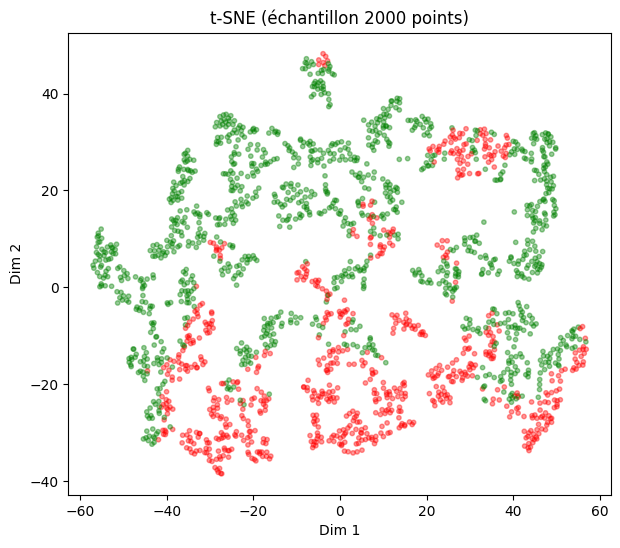

In [14]:
plt.figure(figsize=(7,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1],
            c=np.where(y_sub==1,"green","red"), s=10, alpha=0.4)
plt.title("t-SNE (échantillon 2000 points)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


In [18]:
import pandas as pd

df_tsne = pd.DataFrame({
    "Dim1": X_tsne[:,0],
    "Dim2": X_tsne[:,1],
    "distance": X_sub[:,0],
    "speed": X_sub[:,1],
    "height": X_sub[:,2],
    "weather": X_sub[:,3],
    "decision": y_sub
})

df_tsne.head()
corr = df_tsne[["Dim1","Dim2","distance","speed","height","weather"]].corr()
corr


,Dim1,Dim2,distance,speed,height,weather
Dim1,1.000000,0.062480,0.031113,0.963343,-0.097693,-0.020815
Dim2,0.062480,1.000000,0.936793,0.032247,-0.002816,-0.037115
distance,0.031113,0.936793,1.000000,0.006019,-0.001954,-0.042876
speed,0.963343,0.032247,0.006019,1.000000,-0.028221,-0.026213
height,-0.097693,-0.002816,-0.001954,-0.028221,1.000000,-0.024139
weather,-0.020815,-0.037115,-0.042876,-0.026213,-0.024139,1.000000


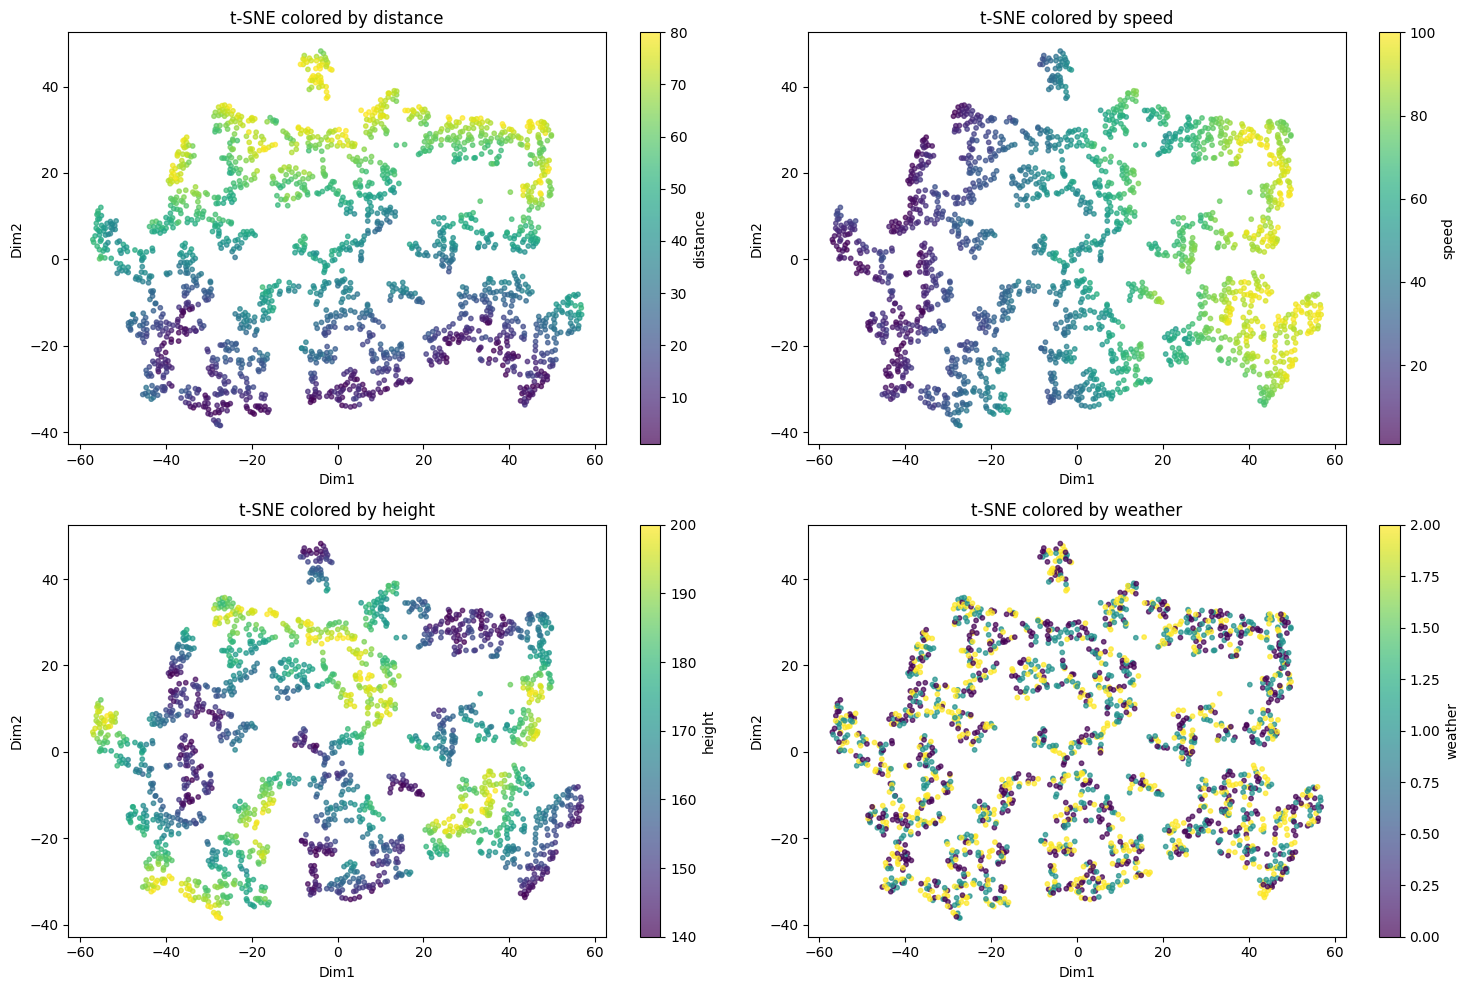

In [19]:
import matplotlib.pyplot as plt

vars_to_plot = ["distance","speed","height","weather"]

plt.figure(figsize=(15,10))
for i, var in enumerate(vars_to_plot):
    plt.subplot(2,2,i+1)
    sc = plt.scatter(df_tsne["Dim1"], df_tsne["Dim2"],
                     c=df_tsne[var], cmap="viridis", s=10, alpha=0.7)
    plt.colorbar(sc, label=var)
    plt.title(f"t-SNE colored by {var}")
    plt.xlabel("Dim1")
    plt.ylabel("Dim2")

plt.tight_layout()
plt.show()


Le t-SNE appliqué à un échantillon de 2000 situations affiche une séparation nette entre les décisions « traverse » (vert) et « ne traverse pas » (rouge).
Les dimensions projetées (**Dim 1** et **Dim 2**) n’ont pas d’interprétation directe : ce sont des axes non linéaires optimisés pour préserver les similarités entre points dans l’espace original ($(\text{distance},\ \text{vitesse},\ \text{taille},\ \text{météo})$).

La structure émergente montre que :

* la majorité des non-traversées se regroupent dans la partie basse du graphe, reflétant des situations caractérisées par un petit TTC et donc un rapport défavorable vis-à-vis de ($T_{\text{end}}$),
* les situations sûres se regroupent dans la partie supérieure,
* des zones mixtes apparaissent dans la région ($\text{Dim 1} \in [20,40]$) et ($\text{Dim 2} \in [20,40]$), correspondant aux conditions limites où ( $\text{TTC} \approx T_{\text{end}}$ ) et où la décision est sensible à la vitesse, la météo ou la taille.

Cette visualisation confirme que le modèle sépare bien les situations traversables et non-traversables, tout en mettant en évidence une zone frontière où les deux catégories coexistent.



 **Interprétation du t-SNE et des corrélations Dim1/Dim2**

Le t-SNE projette l’espace d’entrée en dimension 4
$$
(\text{distance},\ \text{speed},\ \text{height},\ \text{weather})
$$
dans un plan 2D $(\text{Dim1},\text{Dim2})$ en préservant principalement les relations de voisinage.
Contrairement au PCA, les axes du t-SNE **ne correspondent pas à des combinaisons linéaires explicites des variables**, mais ils peuvent être interprétés en examinant leurs corrélations avec les variables d’entrée.

Le tableau suivant résume ces corrélations :

|          | distance | speed    | height | weather |
| -------- | -------- | -------- | ------ | ------- |
| **Dim1** | 0.03     | **0.96** | –0.10  | –0.02   |
| **Dim2** | **0.94** | 0.03     | –0.00  | –0.04   |

 **Signification des axes du t-SNE**

 **Dim 1 — Axe quasi-exclusivement lié à la vitesse**

* Corr(speed, Dim1) = **0.96**
* Corr(distance, Dim1) = 0.03 → négligeable
* Corr(height, Dim1) ≈ 0
* Corr(weather, Dim1) ≈ 0

Donc **Dim1 augmente presque linéairement avec la vitesse** :
$
\text{Dim1} \sim \text{speed}
$

Sur le graphique, cela explique pourquoi les points à forte vitesse se regroupent sur la droite, et ceux à faible vitesse sur la gauche.

**Dim 2 — Axe essentiellement lié à la distance**

* Corr(distance, Dim2) = **0.94**
* Corr(speed, Dim2) = 0.03
* Corr(height, Dim2) ≤ 0.01
* Corr(weather, Dim2) ≈ 0

Donc **Dim2 reflète directement la distance au véhicule** :
$
\text{Dim2} \sim \text{distance}
$

Les points proches (5–20 m) apparaissent en bas,
les points éloignés (60–80 m) en haut.

 **Influence marginale des autres variables**

* La taille (height) n’influence quasiment pas la structure du t-SNE.
* La météo (weather), codée 0–2, n’affecte presque pas la géométrie (corr ≈ 0).

Cela est cohérent avec ton modèle : distance et vitesse dominent le calcul du TTC et donc la décision de traversée.


**Interprétation globale du t-SNE**

Le t-SNE reconstruit spontanément une géométrie en 2D où :

* **L’axe horizontal (Dim1) organise les points selon la vitesse** :
  faible vitesse à gauche → forte vitesse à droite.

* **L’axe vertical (Dim2) organise les points selon la distance réelle** :
  faible distance en bas → grande distance en haut.

Cette structure est parfaitement visible sur les 4 heatmaps colorées par variable.

Les décisions « traverse / ne traverse pas » se superposent ensuite sur cette géométrie :

* Les zones rouges (non-traversée) se concentrent en bas (distances faibles),
* Les zones vertes (traversée) se distribuent en haut (distances élevées),
* Avec une dépendance horizontale (vitesse) cohérente avec les heatmaps précédentes.

Le t-SNE confirme donc visuellement le comportement du modèle :
$
\text{La décision dépend principalement du couple (distance, vitesse),}
$
ce que reflète parfaitement la structure 2D obtenue.


# 7.UMAP : STRUCTURE GLOBALE + LOCALE

## 1.UMAP

UMAP combine les avantages du PCA (structure globale) et du t-SNE (structure locale).
Il fournit souvent la séparation la plus claire des classes dans les modèles tabulaires.


c:\Users\svictor\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


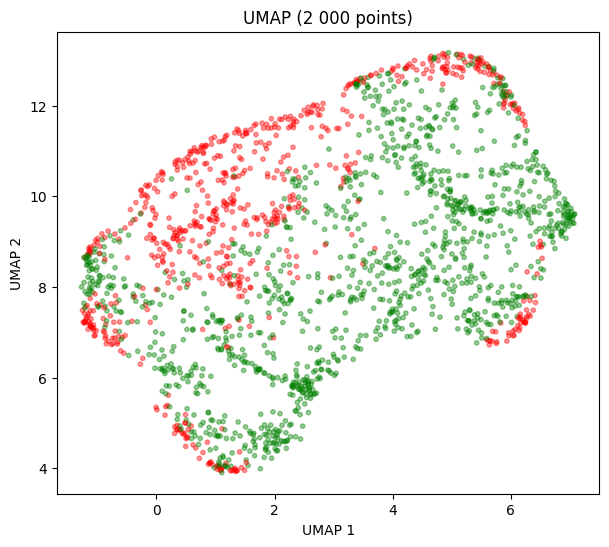

In [22]:
from umap import UMAP
import numpy as np

# Sous-échantillonnage identique à t-SNE
N = len(X)
idx = np.random.choice(N, size=min(2000, N), replace=False)
X_sub = X[idx]
y_sub = y[idx]

umap = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    random_state=0
)

X_umap = umap.fit_transform(X_sub)
plt.figure(figsize=(7,6))
plt.scatter(
    X_umap[:,0], X_umap[:,1],
    c=np.where(y_sub==1, "green", "red"),
    s=10, alpha=0.4
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP (2 000 points)")
plt.show()


In [23]:
import pandas as pd

df_umap = pd.DataFrame({
    "UMAP1": X_umap[:,0],
    "UMAP2": X_umap[:,1],
    "distance": X_sub[:,0],
    "speed": X_sub[:,1],
    "height": X_sub[:,2],
    "weather": X_sub[:,3],
    "decision": y_sub
})

corr_umap = df_umap[["UMAP1","UMAP2","distance","speed","height","weather"]].corr()
corr_umap


,UMAP1,UMAP2,distance,speed,height,weather
UMAP1,1.000000,0.384852,0.476613,-0.795929,-0.098769,-0.008204
UMAP2,0.384852,1.000000,-0.549900,-0.790178,0.105248,-0.044685
distance,0.476613,-0.549900,1.000000,-0.006270,0.009794,0.025815
speed,-0.795929,-0.790178,-0.006270,1.000000,-0.020646,0.024266
height,-0.098769,0.105248,0.009794,-0.020646,1.000000,-0.002150
weather,-0.008204,-0.044685,0.025815,0.024266,-0.002150,1.000000



 **Interprétation exacte des dimensions UMAP**

UMAP ne fournit pas de vecteurs de projection explicites comme le PCA, mais **on peut analyser statistiquement ce que chaque dimension encode** grâce aux corrélations.

Voici ton tableau (pour rappel) :

|           | distance | speed     | height | weather |
| --------- | -------- | --------- | ------ | ------- |
| **UMAP1** | **0.48** | **–0.80** | –0.10  | –0.01   |
| **UMAP2** | –0.55    | **–0.79** | +0.10  | –0.04   |

--

**1. Que représente UMAP 1 ?**


**UMAP 1 encode une combinaison "vitesse + distance", dominée par la vitesse.**


* Forte corrélation **négative** avec la vitesse :
  [
  \mathrm{corr}(UMAP1, speed) = -0.80
  ]
  → Plus la vitesse est élevée, plus UMAP1 diminue.

* Corrélation **positive** modérée avec la distance :
  [
  \mathrm{corr}(UMAP1, distance) = 0.48
  ]
  → Les grandes distances tendent à augmenter UMAP1.

* Taille et météo ont un effet négligeable
  ((|corr| < 0.1)).

** Interprétation scientifique :**

UMAP 1 est une dimension **hybride** qui ordonne le continuum :

$
(distance\ \text{grand},\ speed\ \text{faible})
\quad\to\quad
UMAP1\ \text{haut}
$

$
(distance\ \text{faible},\ speed\ \text{fort})
\quad\to\quad
UMAP1\ \text{bas}
$

Autrement dit :

 **UMAP1 encode la dimension dynamique du risque (interaction distance × vitesse), dominée par la vitesse.**



 **2. Que représente UMAP 2 ?**


**UMAP 2 encode surtout vitesse et distance, mais dans une direction orthogonale à UMAP1.**


* **corr(UMAP2, speed) = -0.79**
  → Comme UMAP1, UMAP2 diminue lorsque la vitesse augmente.

* **corr(UMAP2, distance) = -0.55**
  → UMAP2 diminue aussi quand la distance diminue.

* L’effet de la taille est marginal ((0.10)).

* L’effet de la météo est négligeable (–0.04).

**Interprétation scientifique :**

UMAP 2 capture un autre axe de la structure du binôme :

$
(speed,\ distance)
$

mais orienté différemment d’UMAP 1, ce qui explique pourquoi les points ne s’alignent pas simplement en diagonale.

Ce deuxième axe semble distinguer :

$
UMAP2\ \text{haut} \approx \text{vitesses modérées + distances longues}
$

$
UMAP2\ \text{bas} \approx \text{vitesses fortes + distances courtes}
$

 **UMAP2 encode une seconde composante du risque dynamique, complémentaire d’UMAP1.**

 **3. Taille et météo ont un effet quasi nul**

Les corrélations sont extrêmement faibles :

* Taille : ( |corr| \approx 0.1 )
* Météo : ( |corr| < 0.05 )

 **UMAP ne les détecte pas comme dimensions structurantes de l’espace 4D**, ce qui confirme ce que montrent aussi :

* les heatmaps taille × météo,
* les heatmaps vitesse × météo.


> **Les deux dimensions UMAP capturent presque exclusivement la structure géométrique liée au couple (distance, vitesse), c’est-à-dire la dynamique du temps-avant-collision.**
>
> * **UMAP 1** est fortement corrélé à la vitesse ((-0.80)) et modérément à la distance ((+0.48)) : il représente une **dimension de risque dynamique dominée par la vitesse**.
> * **UMAP 2** est également corrélé à la vitesse ((-0.79)) mais dans une direction indépendante, et anti-corrélé à la distance ((-0.55)) : il représente une **seconde dimension orthogonale du risque dynamique**.
> * Taille et météo ont une influence très faible, confirmant qu’elles n’organisent pas la géométrie globale de l’espace décisionnel.

